In [82]:
from datasets import get_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
from configs.get_configs import get_config


class DotDict(dict):
    def __getattr__(self, key):
        return self[key]
    def __setattr__(self, key, val):
        if key in self.__dict__:
            self.__dict__[key] = val
        else:
            self[key] = val

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
root = '/cluster/work/igp_psr/ai4good/group-2a/mathias/wavegan/eval/inception/wavs'
files = os.listdir(root)
import torchaudio
for f in files:
    f = os.path.join(root, f)
    audio, sr = torchaudio.load(f)
    pad_len = 16384 - audio.shape[-1] - 1
    audio=torch.nn.functional.pad(audio, pad = (audio.shape[0], pad_len))
    torchaudio.save(f, audio, sr, encoding="PCM_S", bits_per_sample=16)

In [50]:
import torch
from evaluation import evaluate
torch.cuda.device_count()

2

In [54]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

817

In [68]:
!wandb offline

Usage: wandb [OPTIONS] COMMAND [ARGS]...
Try 'wandb --help' for help.

Error: No such command 'deactivate'.


# Metrics Evluation

In [150]:
import pandas as pd
import glob
import json
root = 'pfgm_128_deep_v2/ckpt_500000'
files = glob.glob(f"{root}/*/metrics.txt")

In [151]:
files

['pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_75_zmax_200_zmin_0.0001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_75_zmax_200_zmin_0.0001_un_5000_seed_69/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_100_zmax_150_zmin_0.0001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_improved_euler_N_25_zmax_45_zmin_0.0001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_50_zmax_50_zmin_1e-05_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_50_zmax_25_zmin_0.0001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_200_zmax_45_zmin_0.0001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_improved_euler_N_25_zmax_150_zmin_0.001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_50_zmax_25_zmin_0.001_un_5000_seed_49/metrics.txt',
 'pfgm_128_deep_v2/ckpt_500000/os_torchdiffeq_N_75_zmax_200_zmin_0.0001_un_5000_se

In [165]:
def etract_configs(path):
    cfgs = path.split('/')[-2].replace('improved_euler', 'impeuler')
    cfgs = cfgs.split('_')
    cfg = dict(
        os=cfgs[1],
        N=cfgs[3],
        zmax=cfgs[5],
        zmin=cfgs[7],
        un=cfgs[9],
        seed=cfgs[11]
    )
    nfe_path = path.replace('metrics', 'nfe')
    t_path = path.replace('metrics', 'benchmarking')
    
    with open(nfe_path, 'r') as f:
        nfe = f.readlines()
    
    nfe = np.array([int(l.replace('\n', '')) for l in nfe]).mean()
    
    with open(t_path, 'r') as f:
        t = f.readlines()
        
    t = np.array([float(l.replace('\n', '')) for l in t]).mean()
    
    cfg['nfe'] = int(nfe)
    cfg['t'] = t
    cfg['batch_t'] = t / 32
    return cfg
    

In [166]:
df = pd.DataFrame()
frames = []
for idx, f in enumerate(files):
    test = {}
    with open(f, 'r') as jf:
        test = json.load(jf)
    #TODO ADD NFE
    cfg = etract_configs(f)
    test.update(cfg)
    metrics = pd.DataFrame(data=test, index = [idx])
    frames.append(metrics)

df = pd.concat(frames)
df['t/nfe'] = df['t'] / df['nfe']
df

,fid,is,mis,am,ndb,os,N,zmax,zmin,un,seed,nfe,t,batch_t,t/nfe
0,13.535748,3.216519,27.954308,1.260032,1.6,torchdiffeq,75,200,0.0001,5000,49,120,53.940805,1.685650,0.449507
1,13.979012,3.241140,28.357874,1.304716,2.0,torchdiffeq,75,200,0.0001,5000,69,120,69.249297,2.164041,0.577077
2,16.782460,3.047516,20.207646,1.385581,1.6,torchdiffeq,100,150,0.0001,5000,49,116,39.821716,1.244429,0.343291
3,19.770763,2.674958,13.090086,1.488052,1.8,impeuler,25,45,0.0001,5000,49,49,16.929575,0.529049,0.345502
4,18.792234,2.723519,13.730370,1.462785,1.9,torchdiffeq,50,50,1e-05,5000,49,124,57.660257,1.801883,0.465002
5,24.181989,2.258865,8.070657,1.728180,2.0,torchdiffeq,50,25,0.0001,5000,49,100,46.524520,1.453891,0.465245
6,19.596076,2.651318,12.702264,1.493073,1.8,torchdiffeq,200,45,0.0001,5000,49,108,60.271577,1.883487,0.558070
7,16.168937,3.156188,22.553805,1.337301,1.6,impeuler,25,150,0.001,5000,49,49,17.040823,0.532526,0.347772
8,24.071912,2.245144,7.898603,1.729895,1.9,torchdiffeq,50,25,0.001,5000,49,84,39.063577,1.220737,0.465043
9,14.267003,3.248869,29.685370,1.302218,1.9,torchdiffeq,75,200,0.0001,5000,47,120,48.406233,1.512695,0.403385


In [157]:
df_metrics = df[df['os'] == "torchdiffeq"]
df_metrics = df_metrics[df_metrics['N'] == "75"]
df_metrics.describe()

,fid,is,mis,am,ndb,nfe,t,nfe/t
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000
mean,13.636624,3.268825,29.645304,1.275695,1.875000,120.0,53.197794,2.337384
std,0.654467,0.068044,2.093842,0.033573,0.189297,0.0,11.905640,0.493127
min,12.764732,3.216519,27.954308,1.235815,1.600000,120.0,41.194840,1.732870
25%,13.342994,3.234985,28.256982,1.253977,1.825000,120.0,46.603385,2.101713
50%,13.757380,3.245005,29.021622,1.281125,1.950000,120.0,51.173519,2.351840
75%,14.051010,3.278845,30.409944,1.302843,2.000000,120.0,57.767928,2.587511
max,14.267003,3.368772,32.583665,1.304716,2.000000,120.0,69.249297,2.912986


In [161]:
df_tde = df[df['os'] == "torchdiffeq"]
df_rk = df[df['os'] == "rk45"]
df_ie = df[df['os'] == "impeuler"]

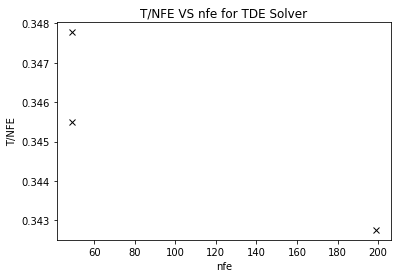

In [164]:
metric = 't/nfe'
param = "nfe"
frame = df_ie

plt.title(f"{metric.upper()} VS {param} for TDE Solver")
plt.plot(frame[param], frame[metric], 'xk')
plt.xlabel(param)
plt.ylabel(metric.upper())
plt.show()

## Libs for Sampling

In [114]:
import datasets
from models import utils as mutils
from models.ema import ExponentialMovingAverage
from models.ema import ExponentialMovingAverage
import losses

from configs.default_audio_configs import get_mels_64, get_mels_128

from evaluation import sampling
from evaluation.utils.mel_to_wav import convert
import datasets
import methods
from utils.checkpoint import save_checkpoint, restore_checkpoint
import os, logging

In [18]:
config = args.config
workdir = args.workdir
eval_folder = args.eval_folder
eval_dir = os.path.join(workdir, eval_folder)
os.makedirs(eval_dir, exist_ok=True)

# setup logger
gfile_stream = open(os.path.join(args.workdir, 'stdout_eval.txt'), 'w')
handler = logging.StreamHandler(gfile_stream)
formatter = logging.Formatter('%(levelname)s - %(filename)s - %(asctime)s - %(message)s')
handler.setFormatter(formatter)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel('INFO')


# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

# Initialize model
net = mutils.create_model(args)
print("Created Model")
optimizer, scheduler = losses.get_optimizer(config, net.parameters())
ema = ExponentialMovingAverage(net.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=net, ema=ema, scheduler=scheduler, step=0)

checkpoint_dir = os.path.join(workdir, "checkpoints")

torch.cuda.empty_cache()
gc.collect()

# Setup methods
if config.training.sde.lower() == 'poisson':
    sde = methods.Poisson(args=args)
    sampling_eps = config.sampling.z_min
    print("--- sampling eps:", sampling_eps)
else:
    raise NotImplementedError(f"Method {config.training.sde} unknown.")


# Wait if the target checkpoint doesn't exist yet
torch.manual_seed(config.seed)
np.random.seed(config.seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

if config.training.sde == 'poisson':
    if config.sampling.ckpt_number > 0:
        ckpt_filename = os.path.join(checkpoint_dir, "checkpoint_{}.pth".format(config.sampling.ckpt_number))
        ckpt_path = os.path.join(checkpoint_dir, f'checkpoint_{config.sampling.ckpt_number}.pth')
    else:
        raise ValueError("Please provide a ckpt_number!")

if not os.path.exists(ckpt_filename):
    print(f"{ckpt_filename} does not exist! Loading from meta-checkpoint")
    ckpt_filename = os.path.join(checkpoint_dir, os.pardir, 'checkpoints-meta', 'checkpoint.pth')
    if not os.path.exists(ckpt_filename):
        print("No checkpoints-meta")

# Wait for 2 additional mins in case the file exists but is not ready for reading
print("Loading from ", ckpt_path)
try:
    state = restore_checkpoint(ckpt_path, state, map_location=config.device)
    print("State Loaded")
except Exception as e:
    print("Loading Failed!")
    print(e)
    time.sleep(60)
    try:
        state = restore_checkpoint(ckpt_path, state, map_location=config.device)
    except Exception as e:
        time.sleep(120)
        state = restore_checkpoint(ckpt_path, state, map_location=config.device)

        
ckpt = config.sampling.ckpt_number
ema.copy_to(net.parameters())

# Build the sampling function when sampling is enabled
if config.eval.enable_sampling:
    sampling_shape = (config.eval.batch_size,
                      config.data.num_channels,
                      config.data.image_height, config.data.image_width)
    sampling_fn = sampling.get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps, net)
    
print("DONE!")

BUILDING MODEL...
MODEL BUILT!
Created Model
--- sampling eps: 0.0001
Loading from  pfgm_128_deep_v2/checkpoints/checkpoint_500000.pth
State Loaded
DONE!


In [19]:
import gc
torch.cuda.empty_cache()
gc.collect()

12

In [20]:
num_sampling_rounds = config.eval.num_samples // config.eval.batch_size + 1
# Directory to save samples. Different for each host to avoid writing conflicts
this_sample_dir = os.path.join(eval_dir, f"ckpt_{ckpt}")
audio_dir = os.path.join(this_sample_dir,f"audio_{ckpt}")
os.makedirs(this_sample_dir, exist_ok=True)
os.makedirs(audio_dir, exist_ok=True)

torch.backends.cudnn.benchmark=True
net.eval()

print(f"Sampling for {num_sampling_rounds} rounds...")
start = time.time()
total_samples = 0
for r in range(num_sampling_rounds):
    samples, n = sampling_fn(net)
    total_samples += samples.shape[0]
    print(f"Round {r} nfe={n}")
    break
stop = time.time()

Sampling for 2 rounds...
Round 0 nfe=120


In [21]:
total = stop - start
per_sample = total / total_samples
print("Took: ", total, " seconds for ", total_samples, "\nAverage of ", per_sample)

Took:  63.47312617301941  seconds for  32 
Average of  1.9835351929068565


In [22]:
from librosa.feature.inverse import db_to_power
from librosa.feature.inverse import mel_to_audio

In [23]:
from configs.default_audio_configs import get_mels_128

In [24]:
spec_conf = get_mels_128()
sample_rate = spec_conf.sample_rate
hop_length = spec_conf.hop_length
nfft = spec_conf.nfft

In [25]:
mel_dat = samples
mel_data = mel_dat.squeeze().cpu().numpy()


mel_data /= mel_data.max()
mel_data *= 80
mel_data -= 80

mel_data = db_to_power(mel_data)
audio = mel_to_audio(
    M=mel_data,
    sr=sample_rate,
    n_fft=nfft,
    hop_length=hop_length,
    win_length=hop_length * 4,
    center=True,
    power=1,
    n_iter=32,
    fmin=20,
    fmax=sample_rate / 2.0,
    pad_mode="reflect",
    norm='slaney',
    htk=True
)
audio /= max(audio.max(), -audio.min())

/cluster/home/matvogel/.local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [28]:
import IPython.display as ipd
ipd.Audio(audio[1], rate=sample_rate) # load a local WAV file

# # Metrics

In [1]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [2]:
from evaluation.metrics import compute_metrics
import warnings
warnings.filterwarnings("ignore")
import json
from sklearn.model_selection import ParameterGrid
from evaluation import evaluate
import shutil
import os

In [10]:
%%capture
args = DotDict()
args.workdir = "pfgm_128_deep_v2"
args.checkpoint_dir = "pfgm_128_deep_v2/checkpoints"
args.conf = "128_deep"
args.test = False
args.DDP = False
args.sampling = True
args.config = get_config(args)
args.config.eval.batch_size = 2
args.config.eval.num_samples = 32
args.config.eval.input_mel = "128"
args.config.eval.save_audio = True
args.config.eval.enable_benchmarking = True


args.config.sampling.ode_solver = 'torchdiffeq' # 'improved_euler', 'forward_euler', 'rk45'
args.config.sampling.ckpt_number = 500000
args.config.sampling.N = 200
args.config.sampling.z_max = 75
args.config.sampling.z_min = 1e-4
args.config.sampling.upper_norm = 5000
args.config.seed = 47
args.config.eval.save_mels = False
args.config.eval.save_images = False
args.config.eval.show_sampling = False

In [ ]:
from run_lib import train
args.wandb_group = None
train('cuda', args)

In [11]:
# METRICS ONLY

In [12]:
args.eval_folder = f"os_{args.config.sampling.ode_solver}_N_{args.config.sampling.N}_zmax_{args.config.sampling.z_max}_zmin_{args.config.sampling.z_min}_un_{args.config.sampling.upper_norm}_seed_{args.config.seed}"
#evaluate.run(args)
metrics = compute_metrics(f"{args.workdir}/ckpt_{args.config.sampling.ckpt_number}/{args.eval_folder}/audio")

# Log metrics
with open(f'{args.workdir}/ckpt_{args.config.sampling.ckpt_number}/{args.eval_folder}/metrics.txt', 'w+') as metric_file:
     metric_file.write(json.dumps(metrics))

loading model...
use_gpu True


0audios [00:00, ?audios/s]


NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:21063 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [ ]:
for params in grid:
    # update params
    args.config.sampling.ode_solver = params['solver']
    args.config.sampling.N = params['N']
    args.config.sampling.z_max = params['z_max']
    args.config.sampling.z_min = params['z_min']
    args.eval_folder = f"os_{args.config.sampling.ode_solver}_N_{args.config.sampling.N}_zmax_{args.config.sampling.z_max}_zmin_{args.config.sampling.z_min}_un_{args.config.sampling.upper_norm}_seed_{args.config.seed}"
    # do sampling
    evaluate.run(args)
    # calculate metrics
    metrics = compute_metrics(f"{args.workdir}/ckpt_{args.config.sampling.ckpt_number}/{args.eval_folder}/audio")

    # Log metrics
    with open(f'{args.workdir}/ckpt_{args.config.sampling.ckpt_number}/{args.eval_folder}/metrics.txt', 'w+') as metric_file:
         metric_file.write(json.dumps(metrics))
    
    # make zip of the audio files
    folder =  os.path.join(args.workdir, f"ckpt_{args.config.sampling.ckpt_number}", args.eval_folder, 'audio')
    shutil.make_archive(f'{folder}', 'zip', folder)
    shutil.rmtree(folder)  
    torch.cuda.empty_cache()
    gc.collect()

# # SD

In [7]:
%%capture
args = DotDict()
args.workdir = "sd_128"
args.checkpoint_dir = "sd_128/checkpoints"
args.conf = "sd_128"
args.test = False
args.DDP = False
args.sampling = True
args.config = get_config(args)
args.config.eval.batch_size = 16
args.config.eval.num_samples = 16
args.config.eval.input_mel = "128"
args.config.eval.save_audio = True
args.config.eval.enable_benchmarking = True


args.config.sampling.ode_solver = 'torchdiffeq' # 'improved_euler', 'forward_euler', 'rk45'
args.config.sampling.ckpt_number = 350000
args.config.sampling.N = 100
args.config.sampling.z_max = 50
args.config.sampling.z_min = 1e-4
args.config.sampling.upper_norm = 5000
args.config.seed = 49
args.config.eval.save_mels = False
args.config.eval.save_images = False
args.config.eval.show_sampling = False

param_grid = {
    'N': [50,100,150,200],
    'z_max': [25, 50, 100, 150, 200, 250],
    'z_min': [1e-5, 1e-4, 1e-3, 1e-2],
    'solver': ['torchdiffeq', 'improved_euler', 'rk45']}

grid = ParameterGrid(param_grid)

In [ ]:
for params in grid:
    # update params
    args.config.sampling.ode_solver = params['solver']
    args.config.sampling.N = params['N']
    args.config.sampling.z_max = params['z_max']
    args.config.sampling.z_min = params['z_min']
    args.eval_folder = f"os_{args.config.sampling.ode_solver}_N_{args.config.sampling.N}_zmax_{args.config.sampling.z_max}_zmin_{args.config.sampling.z_min}_un_{args.config.sampling.upper_norm}_seed_{args.config.seed}"
    # do sampling
    evaluate.run(args)
    # calculate metrics
    metrics = compute_metrics(f"{args.workdir}/ckpt_{args.config.sampling.ckpt_number}/{args.eval_folder}/audio")

    # Log metrics
    with open(f'{args.workdir}/ckpt_{args.config.sampling.ckpt_number}/{args.eval_folder}/metrics.txt', 'w+') as metric_file:
         metric_file.write(json.dumps(metrics))
    
    # make zip of the audio files
    folder =  os.path.join(args.workdir, f"ckpt_{args.config.sampling.ckpt_number}", args.eval_folder, 'audio')
    shutil.make_archive(f'{folder}', 'zip', folder)
    shutil.rmtree(folder)
    torch.cuda.empty_cache()
    gc.collect()

## Full evaluation pipeline

In [41]:
!python3 eval_mathias.py

Loading configuration ... 
Read Config: 
data:
  add_noise: true
  category: mel
  centered: false
  channels: 1
  dataset: speech_commands
  image_height: 128
  image_width: 128
  mel_root: mel_datasets/sc09_128_v2
  num_channels: 1
  spec:
    audio_length: 1
    hop_length: 128
    image_size: 128
    nfft: 512
    num_mels: 128
    sample_rate: 16000
    spec_len_samples: 128
  uniform_dequantization: false
device: cuda
eval:
  batch_size: 8
  begin_ckpt: 30
  bpd_dataset: test
  enable_bpd: false
  enable_interpolate: false
  enable_loss: false
  enable_rescale: false
  enable_sampling: true
  end_ckpt: 31
  num_samples: 32
  save_images: true
  show_sampling: false
model:
  attention_type: ddpm
  attn_resolutions: !!python/tuple
  - 16
  beta_max: 20.0
  beta_min: 0.1
  ch_mult: !!python/tuple
  - 1
  - 1
  - 2
  - 2
  - 4
  - 4
  conv_size: 3
  dropout: 0.0
  ema_rate: 0.995
  embedding_type: positional
  fourier_scale: 16
  init_scale: 0.0
  name: ncsnpp_audio
  nf: 128
  nonli

In [167]:
sr = 16000
mel_args = {
      'sample_rate': sr,
      'win_length': 256 * 4,
      'hop_length': 256,
      'n_fft': 1024,
      'f_min': 20.0,
      'f_max': sr / 2.0,
      'n_mels': 80,
      'power': 1.0,
      'normalized': True,
  }
spectrogram = torchaudio.transforms.MelSpectrogram(**mel_args)
audio, sr = torchaudio.load('SpeechCommands/speech_commands_v0.02/one/0a2b400e_nohash_0.wav')
mel = spectrogram(audio)

In [168]:
import glob
import random
SC09 = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

files = glob.glob('SpeechCommands/speech_commands_v0.02/*/*.wav')
files = [f for f in files if f.split('/')[-2] in SC09]

In [169]:
samps = np.random.choice(files, 1000)
samps

array(['SpeechCommands/speech_commands_v0.02/seven/85851131_nohash_3.wav',
       'SpeechCommands/speech_commands_v0.02/three/1a994c9f_nohash_2.wav',
       'SpeechCommands/speech_commands_v0.02/nine/0e6e36c9_nohash_1.wav',
       'SpeechCommands/speech_commands_v0.02/four/5588c7e6_nohash_0.wav',
       'SpeechCommands/speech_commands_v0.02/eight/6565a81d_nohash_0.wav',
       'SpeechCommands/speech_commands_v0.02/seven/db9cfc88_nohash_0.wav',
       'SpeechCommands/speech_commands_v0.02/eight/8dc18a75_nohash_3.wav',
       'SpeechCommands/speech_commands_v0.02/nine/90645155_nohash_0.wav',
       'SpeechCommands/speech_commands_v0.02/two/97101ef3_nohash_0.wav',
       'SpeechCommands/speech_commands_v0.02/two/d7ca14ef_nohash_1.wav',
       'SpeechCommands/speech_commands_v0.02/four/131e738d_nohash_1.wav',
       'SpeechCommands/speech_commands_v0.02/five/b29f8b23_nohash_2.wav',
       'SpeechCommands/speech_commands_v0.02/five/adebe223_nohash_0.wav',
       'SpeechCommands/speech_comma

In [170]:
import librosa
import torchaudio.transforms as TT

In [171]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
      super(AttrDict, self).__init__(*args, **kwargs)
      self.__dict__ = self

  def override(self, attrs):
    if isinstance(attrs, dict):
      self.__dict__.update(**attrs)
    elif isinstance(attrs, (list, tuple, set)):
      for attr in attrs:
        self.override(attr)
    elif attrs is not None:
      raise NotImplementedError
    return self

params = AttrDict(
    # Training params
    batch_size=16,
    learning_rate=2e-4,
    max_grad_norm=None,

    # Data params
    sample_rate=16000,
    n_mels=80,
    n_fft=1024,
    hop_samples=256,
    crop_mel_frames=62,  # Probably an error in paper.

    # Model params
    residual_layers=30,
    residual_channels=64,
    dilation_cycle_length=10,
    unconditional = False,
    noise_schedule=np.linspace(1e-4, 0.05, 50).tolist(),
    inference_noise_schedule=[0.0001, 0.001, 0.01, 0.05, 0.2, 0.5],

    # unconditional sample len
    audio_len = 22050*5, # unconditional_synthesis_samples
)

In [172]:
sr = params.sample_rate
mel_args = {
  'sample_rate': sr,
  'win_length': params.hop_samples * 4,
  'hop_length': params.hop_samples,
  'n_fft': params.n_fft,
  'f_min': 20.0,
  'f_max': sr / 2.0,
  'n_mels': params.n_mels,
  'power': 1.0,
  'normalized': True,
}
mel_spec_transform = TT.MelSpectrogram(**mel_args)

In [173]:
from diffwave.inference import predict as diffwave_predict

model_dir = 'diffwave-ljspeech-22kHz-1000578.pt'

diffwave_samples = []
start = time.time()
for path in samps:
    audio, sr = librosa.load(path, sr=sr)
    with torch.no_grad():
        spectrogram = mel_spec_transform(torch.tensor(audio))
        spectrogram = 20 * torch.log10(torch.clamp(spectrogram, min=1e-5)) - 20
        spectrogram = torch.clamp((spectrogram + 100) / 100, 0.0, 1.0)
    audio, sample_rate = diffwave_predict(spectrogram, model_dir, fast_sampling=True)
    diffwave_samples.append(audio)
stop = time.time()

In [174]:
print((stop-start) / 1000)

0.16231622552871705


In [83]:
import soundfile as sf
import torchaudio
root = os.path.abspath('./audio_samples/diffwave/')
#os.makedirs(root)

for i, audio in enumerate(diffwave_samples):
    torchaudio.save(os.path.join(root,f"sample_{i}.wav"), audio.cpu(), sr)

torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])
torch.Size([1, 16128])


In [60]:
import IPython.display as ipd
ipd.Audio(diffwave_samples[8], rate=sample_rate) # load a local WAV file

In [ ]:
start_diff = time.time()
for _ in range(32):
    audio, sample_rate = diffwave_predict(spectrogram, model_dir, fast_sampling=True)
stop_diff = time.time()

In [ ]:
print(stop_diff-start_diff)

In [ ]:
import IPython.display as ipd
ipd.Audio(audio[0].cpu().numpy(), rate=sample_rate) # load a local WAV file

In [ ]:
start = time.time()
evaluate(args)
stop = time.time()

In [ ]:
print(stop-start)

In [ ]:
for i, item in enumerate(trainds):
    if i>1: break
    print(item.max(), item.min())

In [ ]:
for i, (item, path) in enumerate(trainds):
    if i>25: break
    spec = item[0][0].numpy()
    print(spec.min(), spec.max(), spec.mean())
    print(path[0])
    plt.figure()
    plt.imshow(spec)
    plt.show()
    plt.figure()
    plt.imshow(spec_demean)
    plt.show()

In [ ]:
# Calculate norms on CIFAR10 for comparison
import torchvision
cf10 = torchvision.datasets.CIFAR10(root='.', download=True)

norms_2_cf = []
norms_cf = []
for item in tqdm(cf10):
    pic = np.array(item[0]) / 255.0
    norm_2 = np.sqrt(pic.ravel()**2)
    norms_2_cf.append(norm_2)
    norm = pic.ravel()**2
    norms_cf.append(norm)

In [ ]:
norms_cf = np.array(norms_cf)
norms_2_cf = np.array(norms_2_cf)

print(norms_cf.sum())

In [ ]:
norms_2 = []
norms = []
for batch in tqdm(trainds):
    for item in batch:
        #scale to 0-1
        item += 1
        item /= 2.0
        norm = item.numpy().ravel()**2
        norms.append(norm)
        norm_2 = np.sqrt(item.numpy().ravel()**2)
        norms_2.append(norm_2)

In [ ]:
gc.collect()

In [ ]:
norms = np.array(norms)

In [ ]:
cfm = norms_cf.mean()
nm = norms.mean()

In [ ]:
nm/cfm * 32

In [ ]:
norms.sum()

In [ ]:
156607710 / 44138412

In [ ]:
print(np.array(norms).mean(), np.array(norms_2).mean())

In [ ]:
0.007212365 / .2873594542857112 * 32

In [ ]:
.032030698 / .4733630004850902

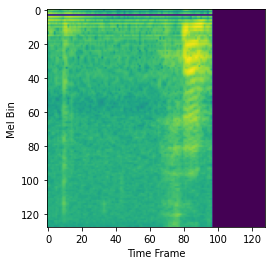

In [81]:
dat = np.load('mel_datasets/sc09_128_v2/seven/990ebd1f_nohash_0.npy')
#plt.title("Mel Spectrogram of seven/990ebd1f_nohash_0")
plt.imshow(dat)
plt.xlabel("Time Frame")
plt.ylabel("Mel Bin")
plt.show()